<h1> Approximating a region of the sine function </h1>

In this notebook we will approximate a region of the sine function with a neural network to get a sense of how architecture and hyperparameters affect neural network performance. We will be introducing Pytorch Neural Network structure, Pytorch datasets and dataloaders and optimizers

<img src="sine_wave.gif" width="1200" align="center">


In [26]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from IPython.display import clear_output

dev = torch.device(
    "cpu") if torch.cuda.is_available() else torch.device("cpu")

<h2> Pytorch Datasets and Dataloaders </h2>
Pytorch has a huge number of functionalities that make training our neural networks very easy! One of those functionalities is the Pytorch dataset and dataloader (they are real life-savers!). The "dataset" class is an object that "stores" our dataset either directly (it loads all the data in the initialisation function) or indirectly (it loads the image paths during the initialisation function and only loads them when it needs to - for large image-based datasets this is usually the only way to do it).We will see how we can create our own Pytorch dataset soon!<br>
These datasets then are used to create a "dataloader" object that is "iterable". The Pytorch dataloader will take our dataset and randomly shuffle it (if we tell it to), it will also divide the dataset into "mini-batches" which are groups of datapoints of a fixed size (the batch size). Our Neural Network is then trained through a single step of GD on this mini-batch. As we iterate through the dataloader, the dataloader will pass us a new unique mini-batch until the whole dataset has been passed to us. One whole loop through the dataset is called an "epoch", during every epoch the dataset is re-shuffled so the mini-batches are all random. This random sampling of the dataset and training on mini-batches (instead of performing GD on the whole dataset) is called Stochastic Gradient Descent (SGD)<br>
Note: If the whole dataset does not evenly divide into mini batches then in the last iterator we will just be passed whatever is left over!

<h3> Creating a Pytorch dataset </h3>
The dataset we will be creating will be points from a "noisey" sine wave.<br>
The Pytorch dataset class has three essential parts:<br>
The __init__ function (as most Python classes do)<br>
The __getitem__ function (this is called during every iteration)<br>
The __len__ function (this must return the length of the dataset)

In [27]:
#Create a "SineDataset" class by importing the Pytorch Dataset class
class SineDataset(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, num_datapoints):
        #Lets generate the noisy sinewave points
        
        #Create "num_datapoints" worth of random x points using a uniform distribution (0-1) using torch.rand
        #Then scale and shift the points to be between -9 and 9
        self.x_data = (18*torch.rand(num_datapoints, 1)-9).to(dev)
        
        #Calculate the sin of all data points in the x vector and the scale amplitude down by 2.5
        self.y_data = (torch.sin(self.x_data)/2.5).to(dev)
        
        #Add some gaussian noise to each datapoint using torch.randn_like 
        #(scale the noise down a bit by about 20 - see how different noise levels effects your model)
        #Note:torch.randn_like will generate a tensor of gaussein noise the same size 
        #and type as the provided tensor
        self.y_data += torch.randn_like(self.y_data)/20

    def __getitem__(self, index):
        #This function is called by the dataLOADER class whenever it wants a new mini-batch
        #The dataLOADER class will pass the dataSET and number of datapoint indexes (mini-batch of indexs)
        #It is up to the dataSET's __getitem__ function to output the corresponding input datapoints 
        #AND the corresponding labels
        x = self.x_data[index]
        y = self.y_data[index]
        
        return x, y
        #Note:Pytorch will actually pass the __getitem__ function one index at a time
        #If you use multiple dataLOADER "workers" multiple __getitem__ calls will be made in parallel
        #(Pytorch will spawn multiple threads)

    def __len__(self):
        #We also need to specify a "length" function, Python will use this fuction whenever
        #You use the Python len(function)
        #We need to define it so the dataLOADER knows how big the dataSET is!
        return len(self.x_data)

In [28]:
18*torch.rand(20, 1)-9


tensor([[-8.2822],
        [-7.7764],
        [-7.4892],
        [ 5.7709],
        [ 3.1650],
        [ 5.0701],
        [ 3.6023],
        [-4.7881],
        [ 0.1103],
        [-7.9537],
        [ 8.4191],
        [-7.2046],
        [ 5.4349],
        [-2.6617],
        [-2.3213],
        [-7.8213],
        [-6.7288],
        [ 3.2943],
        [-3.6935],
        [ 3.9794]])

Now that we've defined our dataset, lets create an instance of it for training and testing and then create  dataloaders to make it easy to iterate

In [29]:
n_x_train = 30000   # the number of training datapoints
n_x_test = 8000     # the number of testing datapoints
batch_size = 64

#Create an instance of the SineDataset for both the training and test set
dataset_train = SineDataset(n_x_train)
dataset_test  = SineDataset(n_x_test)

#Now we need to pass the dataSET to the Pytorch dataLOADER class along with some other arguments
#batch_size - the size of our mini-batches
#shuffle - whether or not we want to shuffle the dataset
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)



Lets visualise the dataset we've created!!

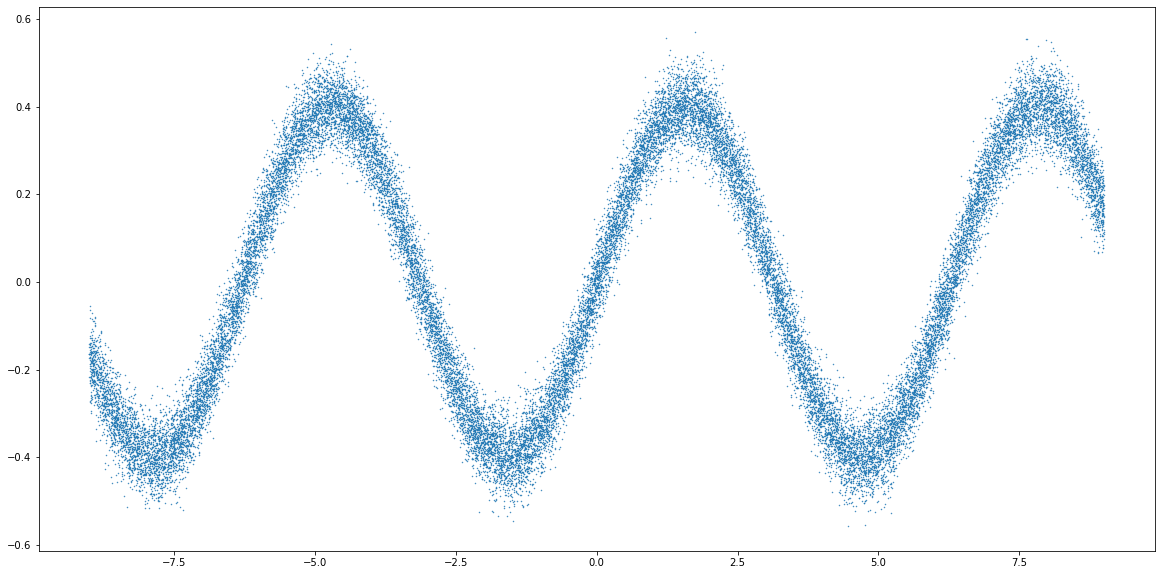

In [30]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(dataset_train.x_data.to("cpu"), dataset_train.y_data.to("cpu"), s=0.2)
#Note:see here how we can just directly access the data from the dataset class

<h2> Neural Network Architecture</h2>
Up until now we have only created a single linear layer with an input layer and an output layer. In this Lab we will start to create multi-layered networks with many "hidden" layers separated by "activation functions" that give our networks "non-linearities". If we didn't have these activation functions and simple stacked layers together, our network would be no better than a single linear layer! Why? Because multiple sequential "linear transformations" can be modeled with just a single linear transformation. This is easiest to understand with matrix multiplications (which is exactly what happens inside a linear layer).<br>

$M_o = M_i*M_1*M_2*M_3*M_4*M_5$<br>
Is the same as<br>
$M_o = M_i*M_T$<br>
Where<br>
$M_T = M_1*M_2*M_3*M_4*M_5$<br>

Aka multiplication with several matrices can be simplified to multiplication with a single matrix.<br>

So what are these nonlinear activation functions that turn our simple linear models into a power "nonlinear function approximator"? Some common examples are:<br>
1. relu
2. sigmoid
3. tanh

Simply put they are "nonlinear" functions, the simplest of which is the "rectified linear unit" (relu) which is "piecewise non-linear".

NOTE: The term "layer" most commonly refers to the inputs or outputs of the weight matrix or activations functions and not the linear layer or activation layer themselves. Output layers in between two "linear layers" are called "hidden layers". You can imagine them "inside" the neural network with us only being able to see the input and output layers. To confuse things even further the outputs of activation functions are also commonly called "activations"

<h3>Pytorch nn.Module</h3>
Now we can define a Pytorch model to be trained!<br>
To do so we use the Pytorch nn.Module class as the base for defining our network. Just like the dataset class, this class has a number of important functions.

In [31]:
#Define our network class by using the nn.module
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    ##Here we initialise our network and define all the layers we need
    def __init__(self):
        #Perform initialization of the pytorch superclass, this will allow us to inherit 
        #functions from the nn.Module class
        super(ShallowLinear, self).__init__()
        
        # Define network layer dimensions
        # These numbers correspond to each layer:
        #[input, hidden_1, hidden_2, hidden_3, output]
        D_in, H1, H2, H3, D_out = [1, 64, 64, 64, 1]
        
        #Define the linear layers we will need
        #Note: the output of one layer must be the same size 
        #as the input to the next!
        self.linear1 = torch.nn.Linear(D_in, H1, bias=False)
        self.linear2 = torch.nn.Linear(H1, H2, bias=False)
        self.linear3 = torch.nn.Linear(H2, H3, bias=False)
        self.linear4 = torch.nn.Linear(H3, D_out, bias=True)

    def forward(self, x):
        #This function is an important one and we must create it or pytorch will give us an error!
        #This function defines the "forward pass" of our neural network
        #and will be called when we simply call our network class
        #aka we can do net(input) instead of net.forward(input)
        
        #Lets define the sqeuence of events for our forward pass!
        #We'll use a tanh activation function here
        #You can experiment with other activation functions!
        x = self.linear1(x)
        x = nn.functional.relu(x)
        
        x = self.linear2(x)
        x = nn.functional.relu(x)
        
        x = self.linear3(x)
        x = nn.functional.relu(x)

        x = self.linear4(x)

        
        #Note we re-use the variable x as we don't care about overwriting it 
        #though in later labs we will want to use earlier hidden layers
        #later in our network!
        return x


## Define training methods for the model
These functions will be used to train and test the model for a single epoch of the data, lets see how we can use what we already know to construct a general training loop

In [32]:
def train_model(model, optimizer, dataloader, loss_fn, loss_logger):
    
    for x, y in dataloader:

        # Run forward calculation
        y_predict = model(x)

        # Compute loss.
        loss = loss_fn(y_predict, y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights
        # of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        #log the loss so we can visualise the training plot later
        loss_logger.append(loss.item())

    return loss_logger

## Define testing methods for the model
These methods are like training, but we don't need to update the parameters of the model anymore because when we call the test() method, the model has already been trained. Instead, this method just calculates the predicted y values and returns them, AKA the forward pass.

In [33]:
def test_model(model, dataloader, loss_fn, loss_logger, gather_outputs = False):

    if gather_outputs:
        data_outputs = []
    #the statement "with torch.no_grad()" will tell pytorch not to keep track
    #of the computations within the indentation
    #it's an optimisation step that helps the evaluation step run faster
    #as we don't need gradients here as we are not training
    with torch.no_grad():
        for x, y in dataloader:

            # Run forward calculation
            y_predict = model(x)

            # Compute loss.
            loss = loss_fn(y_predict, y)

            #log the loss so we can visualise the training plot later
            loss_logger.append(loss.item())
            
            #when we want to visualise the quality of the outputs
            #we can set gather_outputs to True and the function will 
            #collect the models predicted outputs
            if gather_outputs:
                data_outputs.append(y_predict.to("cpu").data.numpy())

        if gather_outputs:
            return loss_logger, np.concatenate(data_outputs)
        else:
            return loss_logger

## Define plotting method for loss
This is a plotting method for looking at the behavior of the loss over training iterations.

In [34]:
def plot_loss(losses, show=True):
    fig = plt.gcf()
    fig.set_size_inches(8,6)
    ax = plt.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    plt.plot(x_loss, losses)

    if show:
        plt.show()

    plt.close()

## Define hyperparameters,  model and optimizer

Here we define the following parameters for training:

- batch size (which has already been defined)
- learning rate
- number of training epochs
- optimizer
- loss function

Ideally, numeric parameters would be tested empirically with an exhaustive search. When testing manually, It is recommended to maximize the model fit with one parameter at a time to avoid confounding your results. 

Try these learning rates:
- 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5

Try these optimizers:
- `optim.SGD(shallow_model.parameters(), lr=learning_rate)`
- `optim.Adam(shallow_model.parameters(), lr=learning_rate)`

See the pytorch documentation pages for an extensive list of options:
- Optimizers: http://pytorch.org/docs/master/optim.html#algorithms
- Loss: http://pytorch.org/docs/master/nn.html#id46

Read this page for a detailed comparison of optimizers: http://ruder.io/optimizing-gradient-descent/



In [35]:
import torch.nn.functional as F

# Define the hyperparameters
learning_rate = 5e-3
nepochs = 50

# create model
shallow_model = ShallowLinear()

# Initialize the optimizer with above parameters
optimizer = optim.SGD(shallow_model.parameters(), lr=learning_rate)

# Define the loss function
loss_fn = F.mse_loss  # mean squared error

## Initiate training, plot testing results
Here we put all the previous methods together to train and test the model. This problem is an unusual one in that our loss is the best quantitative metric of the model performance. Classification problems require further analysis of true/false positives/negatives.

Rerun this cell several times without editing any parameters. Is the result the same?

Try a larger batch size, how is the training time affected?

Look at the slope and noise level of the loss plot. Does it look like the training converged on a local minimum?

Try some different hyperparameters and see how accurate you can get your model

In [36]:
#Here we create two lists to store the loss values from training and testing
training_loss_logger = []
testing_loss_logger = []
#Note:create them outside of the train/test cell so they don't get overwritten 
#if we want to run the cell again

In [37]:
#The main train/test cell
#This will run one epoch of training and then one epoch of testing nepochs times
for epoch in range(nepochs):
    training_loss_logger = train_model(shallow_model, optimizer, data_loader_train, loss_fn, training_loss_logger)
    testing_loss_logger = test_model(shallow_model, data_loader_test, loss_fn, testing_loss_logger)
    
    clear_output(True)
    print("Epoch [%d/%d]" %(epoch, nepochs))

Epoch [49/50]


<h3>Lets visualise our results!</h3>

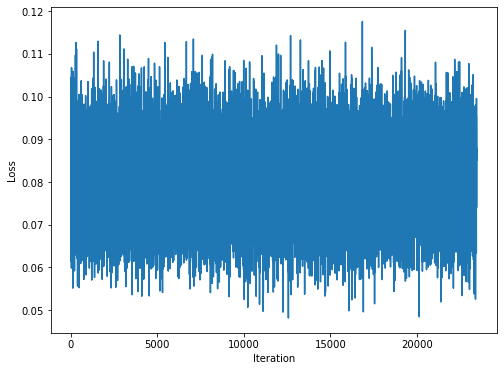

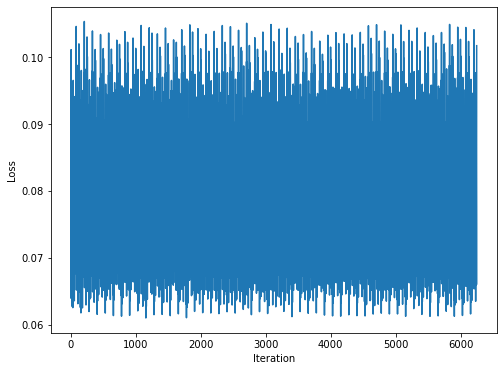

In [38]:
plot_loss(training_loss_logger)
plot_loss(testing_loss_logger)

In [39]:
#set gather_outputs to True and run the test_model function
testing_loss_logger, test_out = test_model(shallow_model, data_loader_test, loss_fn, testing_loss_logger, True)

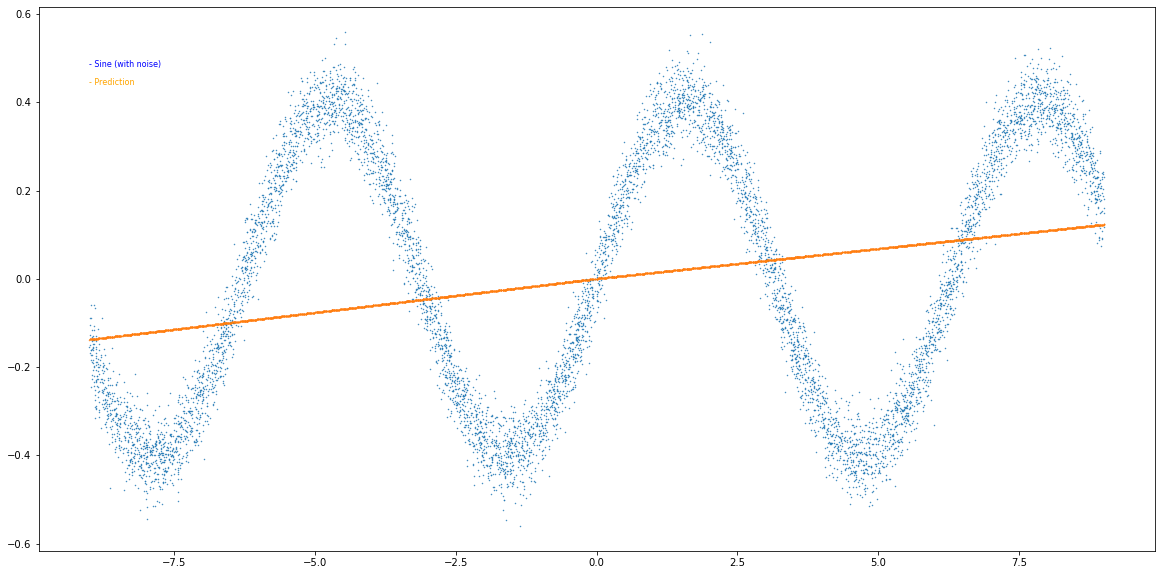

In [40]:
#Plot the testdata against the model's predicted outputs, how accurate is it?
fig = plt.figure(figsize=(20, 10))
plt.scatter(dataset_test.x_data, dataset_test.y_data, s=0.2)
plt.scatter(dataset_test.x_data, test_out, s=0.2)
plt.text(-9, 0.44, "- Prediction", color="orange", fontsize=8)
plt.text(-9, 0.48, "- Sine (with noise)", color="blue", fontsize=8)
plt.show()